In [1]:
import json
import integrated_cell
from integrated_cell import model_utils, utils
import os
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from integrated_cell.utils.plots import tensor2im, imshow

gpu_ids = [0]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()
    
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/"
suffix = "_93300"

networks, dp, args = utils.load_network_from_dir(model_dir, parent_dir, suffix=suffix)

dp.default_return_mesh = False
dp.default_return_patch = False
    
recon_loss = utils.load_losses(args)['crit_recon']    
    
enc = networks['enc']
dec = networks['dec']

enc.train(False)
dec.train(False)

dp.data['test']['CellId'] = dp.csv_data['CellId'].values[dp.data['test']['inds']]
dp.data['train']['CellId'] = dp.csv_data['CellId'].values[dp.data['train']['inds']]


results_dir = '{}/results/kl_demo{}/'.format(model_dir, suffix)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
print("Results dir: {}".format(results_dir))

dp.image_parent = '/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/'

save_dir = results_dir

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth
Results dir: /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09//results/kl_demo_93300/


In [2]:

mode = 'test'
u_classes, class_inds = np.unique(dp.get_classes(np.arange(0, dp.get_n_dat(mode)), mode), return_inverse=True)
u_class_names = dp.label_names[u_classes]


controls = np.array(["Control - " in c for c in u_class_names])

display_order_class_name = np.hstack(
    [u_class_names[~controls], u_class_names[controls]]
)
display_order_class_id = np.hstack([u_classes[~controls], u_classes[controls]])


im, label, ref = dp.get_sample(mode)

ref = ref.cuda()
im = im.cuda()

label_onehot = utils.index_to_onehot(label, len(u_classes)).cuda()

with torch.no_grad():
    z = enc(im, ref, label_onehot)
    z = z[0]
    struct = dec(z.normal_(), ref, label_onehot)

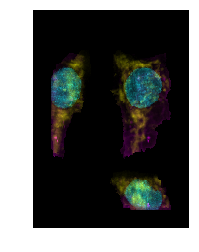

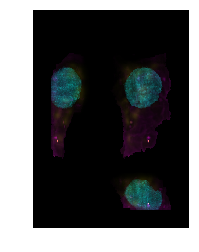

torch.Size([32, 3, 160, 96, 64])
torch.Size([32, 3, 160, 96, 64])


In [3]:
import integrated_cell.utils.plots as plots

from aicsimageio.writers import OmeTiffWriter

im_gen = torch.cat([ref[:,[0]], struct, ref[:,[1]]], 1)
im_real = torch.cat([ref[:,[0]], im, ref[:,[1]]], 1)

ind = 6

plots.imshow(im_real[[ind]])
plots.imshow(im_gen[[ind]])


print(im_gen.shape)
print(im_real.shape)

def im_proc(im):
    for i, ch in enumerate(im):
        im[i] = ch/torch.max(ch)
    
    return im.cpu().detach().numpy().transpose(3,0,1,2)


with OmeTiffWriter('real.tiff', overwrite_file=True) as writer:
    writer.save(im_proc(im_real[ind]))

with OmeTiffWriter('gen.tiff', overwrite_file=True) as writer:
    writer.save(im_proc(im_real[ind]))



In [4]:
# import importlib
# importlib.reload(integrated_cell.utils.target.plots)

import integrated_cell.utils.target.plots as plots

imsize = [20, 20]

im_classes_real, im_classes_gen = plots.summary_images(dp, enc, dec)

v_divider = np.ones([im_classes_real.shape[0], 25, 3])*255

im_classes = np.hstack([im_classes_real, v_divider, im_classes_gen]).astype('uint8')

plt.figure(figsize=imsize)
plt.axis('off')
plt.imshow(im_classes)

plt.show()
plt.close()

matplotlib.image.imsave('{}/im_summary.png'.format(results_dir), im_classes)


OSError: cannot open resource

In [5]:
import importlib
importlib.reload(integrated_cell.utils.target.plots)

import integrated_cell.utils.target.plots as plots

imsize = [60, 60]


classes_to_use = np.array(['Nuclear envelope', 
                  "Mitochondria", 
                  "Tight junctions", 
                  "Golgi", 
                  "Endoplasmic reticulum", 
                  "Nucleolus (Dense Fibrillar Component)"])


remaining_class_inds = np.sum(np.vstack([u_class_names == class_to_use for class_to_use in classes_to_use]),0) == 0
remaining_classes = u_class_names[remaining_class_inds]

im_classes_v2, im_classes_v2_remaining = plots.summary_images_v2(dp, enc = enc, dec = dec, n_imgs_per_class = 3, classes_to_use = classes_to_use)

plt.figure(figsize=imsize)
plt.axis('off')
plt.imshow(im_classes_v2)
plt.show()
plt.close()

plt.figure(figsize=imsize)
plt.axis('off')
plt.imshow(im_classes_v2_remaining)
plt.show()
plt.close()

matplotlib.image.imsave('{}/im_summary_v2.png'.format(results_dir), im_classes_v2)
matplotlib.image.imsave('{}/im_summary_v2_remaining.png'.format(results_dir), im_classes_v2_remaining)



OSError: cannot open resource

In [6]:
import skimage.external.tifffile as tifffile
    
ind = -6

save_dir = './demo_imgs/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

c_name = display_order_class_name[ind]
c_id = display_order_class_id[ind]


this_class_inds = np.where(class_inds == c_id)[0]

_, label, _ = dp.get_sample(mode, this_class_inds[[0]])

label_onehot = utils.index_to_onehot(label, len(u_classes)).cuda()

z.normal_().cuda()
ref = ref.cuda()

with torch.no_grad():
    im_sampled = dec(z, ref, label_onehot)

im_sampled = torch.cat([ref[:,[0]], im_sampled, ref[:,[1]]], 1).cpu()

for i, im in enumerate(im_sampled):

    im_out = im.numpy().transpose([3, 0, 1, 2])
    
    tifffile.imsave("{}/test_{}.tiff".format(save_dir, i), im_out)


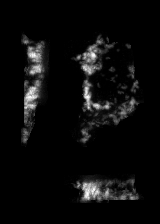

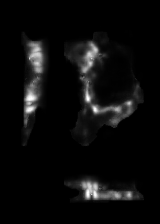

In [7]:
from integrated_cell.models import bvae

mode = 'test'
x, label, ref = dp.get_sample(mode, [341])
x = x.cuda()
ref = ref.cuda()
label_onehot = utils.index_to_onehot(label, dp.get_n_classes()).cuda()

z = enc(x, ref, label_onehot)

z = bvae.reparameterize(z[0], z[1])

x_hat = dec(z, ref, label_onehot)

im = torch.cat([x, x_hat], 3)

im_struct = tensor2im(x)
im_struct_hat = tensor2im(x_hat)
display(PIL.Image.fromarray((im_struct*255).astype('uint8')))
display(PIL.Image.fromarray((im_struct_hat*255).astype('uint8')))

matplotlib.image.imsave('{}/im_sampled_struct.png'.format(results_dir), im_struct)
matplotlib.image.imsave('{}/im_sampled_struct_hat.png'.format(results_dir), im_struct_hat)

In [8]:
from integrated_cell.metrics.embeddings_target import get_latent_embeddings

embeddings_path = '{}/embeddings.pth'.format(results_dir)

if not os.path.exists(embeddings_path):
    embeddings = get_latent_embeddings(enc, dec, dp, recon_loss, batch_size = 32)
    torch.save(embeddings, embeddings_path)

else:
    embeddings = torch.load(embeddings_path)


In [11]:
# embeddings = get_latent_embeddings(enc, dec, dp, recon_loss)

embeddings['test']['target']['mu'].shape

torch.Size([4745, 512])

In [ ]:
#get mito data from labkey and split it into two groups
#binary mitosis labels and resolved (m1, m2, etc) labels

from lkaccess import LabKey
import pandas as pd

lk = LabKey(host="aics")
mito_data = lk.select_rows_as_list(
   schema_name="processing",
   query_name="MitoticAnnotation",
   sort="MitoticAnnotation",
   columns=["CellId", "MitoticStateId", "MitoticStateId/Name", "Complete"]
)

mito_data = pd.DataFrame(mito_data)


mito_binary_inds = mito_data["MitoticStateId/Name"] == 'Mitosis'
not_mito_inds = mito_data["MitoticStateId/Name"] == 'M0'

mito_data_binary = mito_data[mito_binary_inds | not_mito_inds]
mito_data_resolved = mito_data[~mito_binary_inds]

print(np.unique(mito_data["MitoticStateId/Name"]))

modes = ['test', 'train']

for mode in modes:
    mito_states = list()
    for cellId in dp.data[mode]['CellId']:
        mito_state = mito_data_binary["MitoticStateId/Name"][mito_data_binary['CellId'] == cellId].values
        if len(mito_state) == 0:
            mito_state = 'unknown'
            
        mito_states.append(mito_state[0])
        
    dp.data[mode]['mito_state_binary'] = np.array(mito_states)
    dp.data[mode]['mito_state_binary_ind'] = np.array(np.unique(mito_states, return_inverse=True)[1])
    
    

for mode in modes:
    mito_states = list()
    for cellId in dp.data[mode]['CellId']:
        mito_state = mito_data_resolved["MitoticStateId/Name"][mito_data_resolved['CellId'] == cellId].values
        if len(mito_state) == 0:
            mito_state = 'u'
            
        mito_states.append(mito_state[0])
        
    dp.data[mode]['mito_state_resolved'] = np.array(mito_states)
    dp.data[mode]['mito_state_resolved_ind'] = np.array(np.unique(mito_states, return_inverse=True)[1])

In [ ]:
import integrated_cell.utils.plots as ic_plots
from integrated_cell.models import bvae
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle 

plt.style.use('default')

%matplotlib inline

import numpy as np

dpi = 300
figx = 6
figy = 4.5

def embedding_variation(embeddings, figsize = (8, 4), save_path = None):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    colors = cm.viridis(np.linspace(0,1, 1))
    
    color = colors[0]
    
    variation = np.var(embeddings, axis=0)
    variation_argsort = np.argsort(variation)[::-1]
    
    var_dims = np.sort(variation)[::-1]
    ax1.plot(var_dims, color = color)
    ax1.set_xlabel('dimension #')
    ax1.set_ylabel('dimension variation')
    ax1.set_ylim(0, 1.5)

    ax2.plot(np.cumsum(var_dims)/np.sum(var_dims), color = color)
    ax2.set_xlabel('dimension #')
    ax2.set_ylabel('cumulative variation')

    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
        plt.close()
        
    return variation



def plot_dims(X, dims_to_plot=[0,1], colors = None, label = None):
    if colors is None:
        colors = np.zeros(X.shape[0])
        
    plt.scatter(X[:,dims_to_plot[0]], X[:,dims_to_plot[1]], s = 1, c = colors, label = label)
    
def dim_klds(mus, sigmas):
    kl_dims = list()
    for mu, sigma in zip(mus, sigmas):
        _, kl_dim, _ = bvae.kl_divergence(mu.unsqueeze(0), sigma.unsqueeze(0))
        
        kl_dims.append(kl_dim)
    
    return np.vstack(np.vstack(kl_dims))
    

def plot_kld_means(klds):
    kld_means = np.mean(klds, axis=0)
    sorted_inds = np.argsort(kld_means)[::-1]

    plt.plot(kld_means[sorted_inds])

    return kld_means, sorted_inds

mode = 'test'

struct_dim_klds = dim_klds(embeddings[mode]['target']['mu'], embeddings[mode]['target']['sigma'])

plt.figure(figsize = [5,7])

klds_struct, target_sorted_inds = ic_plots.plot_dim_variation(struct_dim_klds)
plt.title('Target structure')
plt.xlabel('latent space dimension #')
plt.ylabel('Average KLD')
plt.ylim([-0.1, 1.5])
plt.subplots_adjust(hspace=0.4)
plt.savefig('{}/dimension_klds.png'.format(results_dir), bbox_inches='tight', dpi=dpi)


struct_embeddings = embeddings['test']['target']['mu'].numpy()
plt.figure(figsize = [5,5])
plot_dims(struct_embeddings, dims_to_plot = target_sorted_inds[0:2], colors = embeddings['test']['target']['class'], label = embeddings['test']['target']['class'].numpy())
plt.title('Highest KLD structure embeddings')
plt.axis('equal')
plt.xlabel('target dimension #1')
plt.ylabel('target dimension #2')
plt.xlim([-4.5, 4.5])
plt.ylim([-4.5, 4.5])
plt.savefig('{}/dimension_target.png'.format(results_dir), bbox_inches='tight', dpi=dpi)


save_klds_path = "{}/klds.pkl".format(results_dir)

with open(save_klds_path, 'wb') as f:
    pickle.dump([klds_struct, target_sorted_inds], f)

In [ ]:
results_dir

In [ ]:
from brokenaxes import brokenaxes
from matplotlib.ticker import MaxNLocator

def plot_kld_dims_broken_axis(kld_list, xlabel = None, ylabel = None, xlims = None, labels = None):
    
    plt_legend = True
    if labels is None:
        plt_legend = False
        labels = ['']*len(kld_list)
    
    for i, (klds, label) in enumerate(zip(kld_list, labels)):
        
        kld_means = np.mean(klds, axis=0)
        sorted_inds = np.argsort(kld_means)[::-1]

        kld_means = kld_means[sorted_inds]

        if xlims is None:
            zero_inds = np.where(kld_means < 0.01)[0]
            xlims = ((0, zero_inds[0]+4), (zero_inds[-1]-3, zero_inds[-1]+1))

        if i == 0:
            bax = brokenaxes(xlims=xlims, wspace=.15)


        if i < 10:
            linestyle = '-'
        elif i < 20:
            linestyle = '--'
        else: 
            linestyle = '-.'
            
            
        bax.plot(np.arange(1, len(kld_means)+1), kld_means, label=label, linestyle = linestyle)

    if plt_legend:
        bax.legend(bbox_to_anchor=(1.04,1), loc="upper left", frameon=False)
        
    if xlabel is not None:
        bax.set_xlabel(xlabel)
    
    if ylabel is not None:
        bax.set_ylabel(ylabel)

    for i, (ax, lims) in enumerate(zip(bax.axs, xlims)):
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        if i == (len(xlims)-1):
            ax.set_xticks([lims[1]])
        else:
            ax.set_xticks(np.arange(lims[0], lims[1]+1,10))
        
    return xlims
    
figsize = [3,5]
    
# plt.figure(figsize = figsize)
# xlims = plot_kld_dims_broken_axis([ref_dim_klds], xlabel = 'Reference latent space dimension #', ylabel = r'$KL(q(z_r|x_r)|p(z)))$')
# plt.savefig('{}/dimension_klds_reference.png'.format(results_dir), bbox_inches='tight', dpi=dpi)
# plt.show()

dpi = 300

plt.figure(figsize = figsize)
plot_kld_dims_broken_axis([struct_dim_klds], xlabel = 'Target latent space dimension #', ylabel = r'$KL(q(z_t|x_t)|p(z)))$')
plt.savefig('{}/dimension_klds_struct.png'.format(results_dir), bbox_inches='tight', dpi=dpi)
plt.show()
plt.close()


plt.figure(figsize = figsize)
classes = embeddings[mode]['target']['class']
klds_by_struct = [struct_dim_klds[classes == u_class] for u_class in u_classes]
plot_kld_dims_broken_axis(klds_by_struct, labels = u_class_names, xlabel = 'Target latent space dimension #', ylabel = r'$KL(q(z_r|x_r, x_t, t)|p(z)))$')
plt.savefig('{}/dimension_klds_combined.png'.format(results_dir), bbox_inches='tight', dpi=dpi)
plt.show()
plt.close()


In [ ]:
z.repeat(3,1)

In [ ]:
classes_to_use = ['Tight junctions', 'Mitochondria', 'Nuclear envelope']

n_imgs_per_class = 1

u_classes, class_inds = np.unique(
    dp.get_classes(np.arange(0, dp.get_n_dat(mode)), mode),
    return_inverse=True,
)

class_names = dp.label_names[u_classes]
controls = np.array(["Control - " in c for c in class_names])

display_order_class_name = np.hstack(
    [class_names[~controls], class_names[controls]]
)
display_order_class_id = np.hstack([u_classes[~controls], u_classes[controls]])

if classes_to_use is not None:
    keep_inds = np.sum(
        np.vstack(
            [
                display_order_class_name == class_to_use
                for class_to_use in classes_to_use
            ]
        ),
        0,
    )
    display_order_class_name = display_order_class_name[keep_inds > 0]
    display_order_class_id = display_order_class_id[keep_inds > 0]

im, label, ref = dp.get_sample(mode, np.arange(n_imgs_per_class))

ref = ref.cuda()
im = im.cuda()

label_onehot = utils.index_to_onehot(label, len(u_classes)).cuda()

enc.train(True)
dec.train(True)

enc.train(False)
dec.train(False)

with torch.no_grad():
    z = enc(im, ref, label_onehot)

z = z[0].cuda()
z = z.repeat(3,1)
    

for c_id, c_name in zip(display_order_class_id, display_order_class_name):
    # the real part
    this_class_inds = np.where(class_inds == c_id)[0]
    np.random.shuffle(this_class_inds)

    class_ims, label, ref = dp.get_sample(
        mode, this_class_inds[0:n_imgs_per_class]
    )
    class_ims = torch.cat([ref[:, [0]], class_ims, ref[:, [1]]], 1)

    class_im_real = [tensor2im([im]) for im in class_ims]

    plt.imshow(class_im_real[0])
    plt.axis('off')
    plt.show()
    plt.close()

    label_onehot = utils.index_to_onehot(label, len(u_classes)).cuda()
    ref = ref.cuda()

    im_out = list()

    label_onehot = label_onehot.repeat(3,1)
    ref = ref.repeat(3,1,1,1,1)
    z = z.normal_().cuda()
    
    with torch.no_grad():
        im_sampled = dec(z, ref, label_onehot)

    im_sampled = torch.cat([ref[:, [0]], im_sampled, ref[:, [1]]], 1)

    plt.imshow(np.concatenate([tensor2im(im) for im in im_sampled], 1))
    plt.axis('off')
    plt.show()
    plt.close()
    

In [ ]:
ref.shape

In [ ]:
im_sampled.shape

In [ ]:
plt.imshow(class_im_real[0])
plt.axis('off')

In [ ]:
# print(np.sum(klds_ref[ref_sorted_inds] > 0.05) + 1)

print(np.sum(klds_struct[target_sorted_inds] > 0.05) + 1)

In [ ]:
# import matplotlib.pyplot as plt
ind = 100
plt.scatter(np.abs(embeddings['test']['target']['mu'][:,target_sorted_inds[ind]]), np.exp(embeddings['test']['target']['sigma'][:,target_sorted_inds[ind]]), s=5)

plt.xlabel('|mu|')
plt.ylabel('logsigma')

# plt.ylim([-.1, .5])
plt.show()


In [ ]:
my_dat = dp.data

data = {}

for mode in ['test']:
    mode_dict = {}
    for k in ['target']:
    
#         if k == 'ref':
#             mult = x[:, [0,2]].numel()
#         if k == 'struct':
#             mult = x[:, [1]].numel()
        
        mode_dict['mse_'+k] = np.mean(embeddings[mode][k]['recon'].numpy(), axis=1)
        
        mode_dict['kld_'+k] = embeddings[mode][k]['kld'].numpy()
        
        embeddings[mode][k]['elbo'] =  -mode_dict['mse_'+k] - mode_dict['kld_'+k]
        mode_dict['elbo_'+k] = embeddings[mode][k]['elbo'] 
        
        
    mode_dict['class'] = embeddings[mode]['target']['class']
    mode_dict['class_names'] = dp.label_names[embeddings[mode]['target']['class']]
    mode_dict['mode'] = [mode]*len(mode_dict['class'])
    
    mode_dict['mitosis_label_binary'] = my_dat[mode]['mito_state_binary_ind']
    mode_dict['mitosis_label_resolved'] = my_dat[mode]['mito_state_resolved_ind']
    
    data[mode] = mode_dict

df_data = pd.DataFrame()
    
for k in data['test']:
    A = data['test'][k]
    try:
        A = A.numpy()
    except:
        pass
    
    A = np.array(A)
    
    df_data[k] = A
    
print('saving stats to: {}/stats.csv'.format(save_dir))

df_data.to_csv('{}/stats.csv'.format(save_dir))  


In [ ]:
# Save embeddings for mu and sigma to csv files

mode = 'test'

for ref_or_target in ['target']:
    for mu_or_sigma in ['mu', 'sigma']:
        embeddings_mat = pd.DataFrame(embeddings[mode][ref_or_target][mu_or_sigma].numpy())
        
        if ref_or_target == 'struct':
            target_name = 'target'
        else:
            target_name = ref_or_target
        
        filename = '{}/embeddings_{}_{}_{}.csv'.format(results_dir, ref_or_target, mu_or_sigma, mode)
        print(filename)
        
        embeddings_mat.to_csv(filename)


In [ ]:
plt.style.use('default')
plt.set_cmap('viridis')

def scatter_df(df, x_ax, y_ax, color_ax, subset = None):
    
    if subset is None:
        subset = np.ones(len(df_data[x_ax]))>0
        
    x = df_data[x_ax][subset]
    y = df_data[y_ax][subset]
    c = df_data[color_ax][subset]
    
    
    _, c = np.unique(c, return_inverse=True)

    plt.scatter(x, y, s = 1, c=c)
    plt.axis('tight')
    plt.xlabel(x_ax)
    plt.ylabel(y_ax)
    plt.title('colored by {}'.format(color_ax))
    

# plt.figure()
# scatter_df(df_data, 'mse_ref', 'kld_ref', 'class', subset=df_data['mode']=='test')
    
plt.figure()
scatter_df(df_data, 'mse_target', 'kld_target', 'class', subset=df_data['mode']=='test')

# plt.figure()
# scatter_df(df_data, 'elbo_ref', 'elbo_struct', 'class', subset=df_data['mode']=='test')

# plt.figure()
# scatter_df(df_data, 'elbo_ref', 'elbo_struct', 'mitosis_label_binary', subset=df_data['mode']=='test')

# plt.figure()
# scatter_df(df_data, 'elbo_ref', 'elbo_struct', 'mitosis_label_resolved', subset=df_data['mode']=='test')



In [ ]:
#Plot the first 24 dimensions

X = embeddings['test']['target']['mu'].numpy()
Y = dp.data['test']['mito_state_binary_ind']

keep_inds = dp.data['test']['mito_state_binary']!='u'

X = X[keep_inds,:]
Y = Y[keep_inds]

subplot_x = 4
subplot_y = 3

n_plots = subplot_x * subplot_y


plt.style.use('default')

plt.figure()
for i in range(n_plots):
    
    dim_x = i*2 
    dim_y = dim_x+1
    
    ax = plt.subplot(subplot_y, subplot_x, i+1)
    
    plt.scatter(X[:,target_sorted_inds[dim_x]], X[:,target_sorted_inds[dim_y]], s=1, c=Y)

    plt.xlim(-5, 5)    
    plt.ylim(-5, 5)
    
# plt.show()

In [ ]:
u_classes, class_inds = np.unique(embeddings[mode]['target']['class'], return_inverse=True)

class_names = dp.label_names[u_classes]
controls = np.array(['Control - ' in c for c in class_names])
display_order = np.hstack([class_names[~controls], class_names[controls]])
display_order_class = np.hstack([u_classes[~controls], u_classes[controls]])


In [ ]:
#Get p-values for P(mitosis)

plt.style.use('default')

u_classes, class_inds = np.unique(embeddings[mode]['target']['class'], return_inverse=True)
class_names = dp.label_names[u_classes]
controls = np.array(['Control - ' in c for c in class_names])
display_order_class_name = np.hstack([class_names[controls], class_names[~controls]])
display_order_class_id = np.hstack([u_classes[controls], u_classes[~controls]])




mode = 'test'
mito_state = 'mito_state_binary'

#statistical stuff
n_perms = 10000

#visual stuff
prct_bounds = [0.01, 99.9]
ps = np.zeros([len(u_classes), 2])

colors = cm.Paired([0, 255])

fontsize = 8

im_scale = 2

subplot_x = 5
subplot_y = 5

plt.figure(figsize=(subplot_x*im_scale,subplot_y*im_scale))

test_stats = np.zeros([n_perms, len(u_classes)])
null_stats = np.zeros([n_perms, len(u_classes)])




c = 0
for class_name, u_class in zip(display_order_class_name, display_order_class_id):
    
    i = u_class
    
    cell_inds = np.where((embeddings[mode]['target']['class'].numpy() == u_class) & (dp.data[mode][mito_state] != 'u'))[0]
    
    n_dat = len(cell_inds)
    
    struct_elbo = embeddings[mode]['target']['elbo'][cell_inds]
    mito_label = dp.data[mode][mito_state + '_ind'][cell_inds]

    mito_inds = np.where(mito_label>0)[0]
#     not_mito_inds = np.where(mito_label==0)[0]
    
    n_mito = len(mito_inds)
    
#     test_stat = np.sum(struct_elbo[mito_inds])
    
    test_stat = np.mean(struct_elbo[np.random.choice(mito_inds, [n_perms, n_mito])], 1)
    null_stat = np.mean(struct_elbo[np.random.choice(n_dat, [n_perms, n_mito])], 1)
    

    test_stats[:,i] = test_stat
    null_stats[:,i] = null_stat
    
    n_bins = 250
    
    all_stat = np.hstack([test_stat, null_stat])
    
    x_lb = np.percentile(all_stat, prct_bounds[0])
    x_hb = np.percentile(all_stat, prct_bounds[1])
    x_bins = np.linspace(x_lb, x_hb, n_bins)
    
    plt.subplot(subplot_y, subplot_x, c+1)

    plt.hist(null_stat, bins = x_bins, color=colors[1], alpha = 1, label='null')
    plt.hist(test_stat, bins = x_bins, color=colors[0], alpha = 0.75, label='mitosis')
    
    
    title_name = class_name
    if '(' in title_name:
        ind = title_name.find('(')
        title_name = title_name[0:ind] + '\n' + title_name[ind:]
    
    plt.title(title_name, fontsize=fontsize, y=0.98)  
    
    plt.yticks([])
    
    if c+1 == subplot_x:
        plt.legend(prop={'size': fontsize}, loc='upper right', shadow=False, framealpha=1)
        
    plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
        
    c += 1
    
plt.subplots_adjust(hspace=0.4)

plt.savefig('{}/p_value_distributions.png'.format(results_dir), dpi=dpi)

In [ ]:
geqs = np.zeros([n_perms, len(u_classes)])
leqs = np.zeros([n_perms, len(u_classes)])

for i in range(n_perms):
    #probability that the null distribution is greater than or equal to the test stat
    geqs[i,:] = np.mean(null_stats >= test_stats[i,:] ,0)
    
    #probability that the null distribution is less than or equal to the test stat
    leqs[i,:] = np.mean(null_stats <= test_stats[i,:] ,0)
    


In [ ]:
plt.style.use('default')
plt.figure(figsize = [10,4])

p_val = 0.05
bonferroni_corr = 2*len(u_classes)
p_val_adj = p_val/bonferroni_corr

y_lim = [-0.001, 0.1]
p_thresh_x = [0,len(u_classes)+1]
p_thresh_y = [p_val_adj, p_val_adj]

colors = ['r', 'k']

geq_medians = np.median(geqs,0)
plot_order = np.argsort(geq_medians)
medians_sorted = geq_medians[plot_order]

plt.subplot(1,2,1)
bp = plt.boxplot(geqs[:,plot_order], showfliers=False, whis=[5, 95], labels = dp.label_names[u_classes][plot_order])
plt.plot(p_thresh_x, p_thresh_y, '--', linewidth=0.4, color='grey')
plt.ylim(y_lim)
plt.xticks(rotation='45', ha='right', fontsize = fontsize)
plt.ylabel(r'P($X \geq x | H_{0}$)')

plt.setp(bp['medians'], color = 'k')
for ticklabel, median in zip(plt.gca().get_xticklabels(), medians_sorted):
    color = colors[p_val_adj <= median]
    ticklabel.set_color(color)


leq_medians = np.median(leqs,0)
plot_order = np.argsort(leq_medians)
medians_sorted = leq_medians[plot_order]

plt.subplot(1,2,2)
bp = plt.boxplot(leqs[:,plot_order], showfliers=False, whis=[5, 95], labels = dp.label_names[u_classes][plot_order])
plt.plot(p_thresh_x, p_thresh_y, '--', linewidth=0.4, color='grey')
plt.ylim(y_lim)
plt.xticks(rotation='45', ha='right', fontsize = fontsize)
plt.ylabel(r'P($X \leq x | H_{0}$)')

plt.setp(bp['medians'], color = 'k')
for ticklabel, median in zip(plt.gca().get_xticklabels(), medians_sorted):
    color = colors[p_val_adj <= median]
    ticklabel.set_color(color)

    
plt.subplots_adjust(wspace=0.25)    

p_vals = np.vstack([geq_medians, leq_medians]).transpose()


plt.savefig('{}/p_value_distributions_bar.png'.format(results_dir), dpi=dpi, bbox_inches='tight')

In [ ]:
dpi

In [ ]:
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

matplotlib.rcParams.update({'font.size': 10})
n_subplot_x = 5
n_subplot_y = 5

dpi = 90

plt.style.use('default')
plt.set_cmap('Paired_r')

mode = 'test'
mito_state = 'mito_state_binary'


mito_state_names = np.unique(dp.data[mode][mito_state][dp.data[mode][mito_state] != 'u'])
mito_state_names = [name.replace('M0', 'Interphase') for name in mito_state_names]

im_scale = 2

plt.figure(figsize=(n_subplot_x*im_scale,n_subplot_y*im_scale))

ax.set_xlabel('reference ELBO')
ax.set_ylabel('target ELBO')

prct_bounds = [0, 100]

n_bins = 50

c = 0
for class_name, u_class in zip(display_order_class_name, display_order_class_id):
    i = u_class

    cell_inds = np.where((embeddings[mode]['target']['class'].numpy() == u_class) & (dp.data[mode][mito_state] != 'u'))[0]

    plt.subplot(n_subplot_y, n_subplot_x, c+1)

    x =  embeddings[mode]['target']['elbo'][cell_inds]
    y = dp.data[mode][mito_state + '_ind'][cell_inds]
    
    
    all_stat = np.hstack([test_stat, null_stat])
    
    x_lb, x_hb = np.percentile(x, prct_bounds)
    x_bins = np.linspace(x_lb, x_hb, n_bins)

    sns.distplot(x[y==1], hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 1}) 
    sns.distplot(x[y==0], hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 1})
    
    plt.xlim([x_lb, x_hb])
    
    title_name = class_name
    if '(' in title_name:
        ind = title_name.find('(')
        title_name = title_name[0:ind] + '\n' + title_name[ind:]

    plt.title(title_name, fontsize=fontsize, y=0.98)  
    plt.yticks([])
        
    plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)

    hyp_ind = np.argmin(p_vals[i])

    p = p_vals[i, hyp_ind]

    s = ''
    if p == 0:
        s = '$H_{0}$: p < {1:1.0e}'.format(hyp_ind+1, 1/n_perms)
    elif p < p_val_adj:
        s = '$H_{0}$: p = {1:1.1e}'.format(hyp_ind+1, p)

#     plt.text(x_lb+1, y_lb+3, s)  
#     plt.ylim(y_lb, y_hb)

    c += 1

#legend    
colors = cm.Paired([255, 0])    
legend_elements = [Line2D([0], [0], marker='o', color = 'w', markerfacecolor=colors[0], markersize=10, label=mito_state_names[0]),
                   Line2D([0], [0], marker='o', color = 'w', markerfacecolor=colors[1], markersize=10, label=mito_state_names[1])]

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), frameon=False)


# Set common labels
plt.gcf().text(0.515, 0.07, 'reference ELBO', ha='center', va='center')
plt.gcf().text(0.1, 0.5, 'density', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(hspace=0.375)

plt.savefig('{}/p_value_elbo_density.png'.format(results_dir), dpi=dpi, bbox_inches='tight')


plt.show()
plt.close()


In [ ]:
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

matplotlib.rcParams.update({'font.size': 10})
n_subplot_x = 5
n_subplot_y = 5



plt.style.use('default')
plt.set_cmap('Paired_r')

mode = 'test'
mito_state = 'mito_state_binary'


mito_state_names = np.unique(dp.data[mode][mito_state][dp.data[mode][mito_state] != 'u'])
mito_state_names = [name.replace('M0', 'Interphase') for name in mito_state_names]

im_scale = 2

plt.figure(figsize=(n_subplot_x*im_scale,n_subplot_y*im_scale))

ax.set_xlabel('reference ELBO')
ax.set_ylabel('target ELBO')

plot_range = [1, 99]
x_lb, x_hb = [-0.5, 0.5]
# y_lb, y_hb = np.percentile(embeddings[mode]['target']['elbo'], plot_range)

y_lb = -1000
y_hb = 100

# y_hb = 1

c = 0
for class_name, u_class in zip(display_order_class_name, display_order_class_id):
    i = u_class

    cell_inds = np.where((embeddings[mode]['target']['class'].numpy() == u_class) & (dp.data[mode][mito_state] != 'u'))[0]

    plt.subplot(n_subplot_y, n_subplot_x, c+1)

    y =  embeddings[mode]['target']['elbo'][cell_inds]
    x = dp.data[mode][mito_state + '_ind'][cell_inds]
    
    sns.violinplot(x = x, y = y, pallette="paired", split=True)

    title_name = class_name
    if '(' in title_name:
        ind = title_name.find('(')
        title_name = title_name[0:ind] + '\n' + title_name[ind:]

    plt.title(title_name, fontsize=8)

    if c%n_subplot_x != 0:
        plt.yticks([])

    if c < (n_subplot_x * (n_subplot_y-1)):
        plt.xticks([])

    hyp_ind = np.argmin(p_vals[i])

    p = p_vals[i, hyp_ind]

    s = ''
    if p == 0:
        s = '$H_{0}$: p < {1:1.0e}'.format(hyp_ind+1, 1/n_perms)
    elif p < p_val_adj:
        s = '$H_{0}$: p = {1:1.1e}'.format(hyp_ind+1, p)

    plt.text(x_lb+1, y_lb+3, s)  
    plt.ylim(y_lb, y_hb)

    c += 1

#legend    
colors = cm.Paired([255, 0])    
legend_elements = [Line2D([0], [0], marker='o', color = 'w', markerfacecolor=colors[0], markersize=10, label=mito_state_names[0]),
                   Line2D([0], [0], marker='o', color = 'w', markerfacecolor=colors[1], markersize=10, label=mito_state_names[1])]

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), frameon=False)


# Set common labels
plt.gcf().text(0.515, 0.07, 'reference ELBO', ha='center', va='center')
plt.gcf().text(0.07, 0.5, 'target ELBO', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(hspace=0.275)

plt.savefig('{}/p_value_elbo_scatter.png'.format(results_dir), dpi=dpi, bbox_inches='tight')

plt.show()




In [ ]:
mito_state_names = np.unique(dp.data[mode][mito_state][dp.data[mode][mito_state] != 'u'])
mito_state_names = [name.replace('M0', 'Interphase') for name in mito_state_names]
mito_state_names

In [ ]:
struct_dim_klds[cell_inds][:, target_sorted_inds[0:2]]

In [ ]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter

from integrated_cell.utils.plots import scatter_im
from integrated_cell.utils.target import sample2im

def get_image(train_or_test, im_id, channels_to_show = [1,1,1]):
    x, _ , ref = dp.get_sample(train_or_test, [im_id])
    
    im = sample2im(x, ref)
    
    im_out = tensor2im(im, proj_xy=False)
    
    alpha = np.expand_dims(np.any(im_out > 0,2).astype(im_out.dtype), 2)

    im_final = np.concatenate([im_out, alpha], 2)
    
    return im_final
    
print(dp.label_names)

x_lb = -5
x_hb = 5

y_lb = -5
y_hb = 5

p_value_elbo_dir = '{}/p_value_elbo_scatter'.format(results_dir)
if not os.path.exists(p_value_elbo_dir):
    os.makedirs(p_value_elbo_dir)

for label_to_print in dp.label_names:

#     label_to_print = 'Microtubules'
    mito_state = 'mito_state_binary'

    u_class = np.where(dp.label_names == label_to_print)[0]
    cell_inds = np.where((embeddings[mode]['target']['class'].numpy() == u_class) & (dp.data[mode][mito_state] != 'u'))[0]

    train_or_test = 'test'

    X = struct_embeddings[cell_inds][:, target_sorted_inds[0:2]]
    
    inset_colors = dp.data[mode][mito_state + '_ind'][cell_inds]
    inset_colors = cm.Paired([0, 255])[::-1][inset_colors]

    def myfunc(i):
        return get_image(train_or_test, cell_inds[i])

    plt.style.use('dark_background')
    plt.figure(figsize=(40, 30))
    ax, ax_inset = scatter_im(X, myfunc, zoom = 1, inset = True, inset_colors = inset_colors, inset_width_and_height=0.17, inset_scatter_size = 50, plot_range = [2, 98])

    ax.set_xlim(x_lb, x_hb)    
    ax.set_ylim(y_lb, y_hb)
    
    ax_inset.set_xlim(x_lb, x_hb)    
    ax_inset.set_ylim(y_lb, y_hb)

    plt.ylabel('Z2', fontsize = 15)
    plt.xlabel('Z1', fontsize = 15)
    plt.title(label_to_print, fontsize = 15)

    plt.savefig('{}/{}.png'.format(p_value_elbo_dir, label_to_print.replace('(', '').replace(')', '')), dpi=90, bbox_inches='tight')

    plt.show()
    plt.close()
